# Sato and Meijering - Benchmark

In [722]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
from skimage.feature import hessian_matrix

In [723]:
def trace_2x2(A):
    return A[..., 0, 0] + A[..., 1, 1]

def det_2x2(A):
    return A[..., 0, 0] * A[..., 1, 1] - A[..., 0, 1] * A[..., 1, 0]

def valeurs_propres_2x2(A):
    """compute eigen values given an hessian array A in 2d"""
    tr = trace_2x2(A)
    det = det_2x2(A)
    delta = tr**2 - 4*det
    return np.stack([(tr - np.sqrt(delta))/2, (tr + np.sqrt(delta))/2], axis=-1)

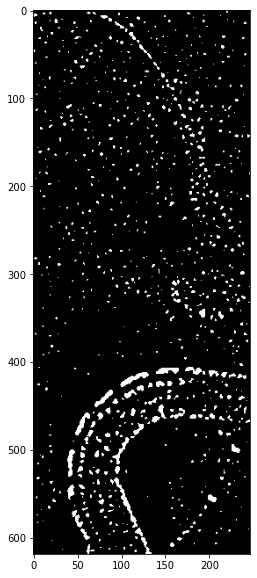

In [724]:
x = np.invert((np.array(Image.open("img/images2/14.jpg").convert('L'))))  # we invert because we want to detect white ridges //
y = np.array(Image.open("img/annotations2/14.jpg").convert('L'))

b = y > 20     # turns the ground truth image into boolean array 

Hrr, Hrc, Hcc = hessian_matrix(x, sigma=2, mode='reflect')   # reflect mode to handle values outside the image borders

H2 = np.zeros(x.shape + (2, 2))   # creation of the tensor with the 2x2 hessian matrix for each pixel
H2[:, :, 0, 0] = Hrr
H2[:, :, 0, 1] = Hrc
H2[:, :, 1, 1] = Hcc
H2[:, :, 1, 0] = Hrc

def meijering_score(H, alpha=1/3):
    """Compute the meijering matrix F for all given pixels of the image whose hessian is given as input
    """
    R = np.array([
        [0, -1],
        [1, 0]
    ])
    Hprime = H + alpha * R.T @ H @ R
    eigen = valeurs_propres_2x2(Hprime)
    l_max = eigen[:, :, 1]
    l_min = l_max.min() 

    F = np.where(l_max < 0, l_max / l_min, 0)
    
    return F

def sato_score(H, alpha1=0.5, alpha2=2.0):
    """Compute the sato matrix F for all given pixels of the image whose hessian is given as input
    """
    eigen = valeurs_propres_2x2(H)
   
    lambda1 = eigen[:, :, 1]
    lambda2 = eigen[:, :, 0]
    lambdac = -lambda2  # because we're in 2d //

    alpha = np.where(lambda1 > 0, alpha2, alpha1)
    
    F = np.where(lambdac != 0, lambdac * np.exp(- lambda1**2 / (2*(alpha * lambdac)**2)), 0)
    
    return F

F = meijering_score(H2)    
#F = sato_score(H2)

plt.imshow(F>0.1573, cmap='gray') #use the best threshold given by the function best_treshold, see below //
plt.show()


In [725]:
def dice(im1, im2):
    """dice metric which takes 2 boolean images of the same shape as input and returns a score from 0, worst to 1, best"""
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [726]:
def best_threshold(filtered, gt):
    """takes as input 2 boolean image, the image we want to review and its associated ground truth"""
    scores = {}
    for i in np.arange(0.0000, 1.0, 0.0001):
        scores[i] = dice((filtered > i),gt)
        
    max_value = max(scores, key=scores.get)
    print('threshold value :', max_value)
    print('dice score :', scores.get(max_value))
    

best_threshold(F, b)


threshold value : 0.1573
dice score : 0.05416712539909722
